In [1]:
import warnings
from pathlib import Path

import gensim

# Widgets
import ipywidgets as widgets
import nltk
import pandas as pd
import pyLDAvis.gensim_models
import seaborn as sns
import spacy
from gensim import corpora
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from ipywidgets import interact
from matplotlib import pyplot as plt
from nltk.corpus import stopwords

# Pakete für NLP
from wordcloud import WordCloud
from ydata_profiling import ProfileReport

InteractiveShell.ast_node_interactivity = "all"

nltk.download("stopwords")  # start the NLTK Downloader and download the stopwords
warnings.filterwarnings("ignore")

F:\Basti\Studium\HSHarz\Analyse von Finanzdaten\.venv\Lib\site-packages\visions\utils\monkeypatches\imghdr_patch.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  from imghdr import tests
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# LDA and WordCloud on Mastodon Posts for the Bavarian State Election!

## Loading the data from Parquet File


In [2]:
toots_path = Path() / "german_toots_small.pqt"
german_sentiment_df = pd.read_parquet(toots_path)
german_sentiment_df = german_sentiment_df[german_sentiment_df.date > pd.to_datetime("2023-9-1")]
german_sentiment_df

,date,day,week,mentioned_party,dominant_party,cleared_content,sentiment
735,2023-09-01 00:27:55,244,35,csu,csu,jan buehlbecker AhaAchja dann veranstaltet söd...,-0.000032
736,2023-09-01 00:23:27,244,35,fw,fw,Der Antisemitismusbeauftragte der Bundesregier...,-0.000027
737,2023-09-01 00:17:34,244,35,fw,fw,Das dem Herrn Aiwanger nach mehreren Tagen imm...,-0.989762
738,2023-09-01 00:00:08,244,35,fw,fw,"'Aktuell wichtiger denn je. Gell, Hubsi…😇 ' Ai...",-0.543437
739,2023-09-01 03:55:45,244,35,fw,fw,"Habe gerade im Deutschlandfunk gehört, dass au...",-0.011672
...,...,...,...,...,...,...,...
5596,2023-11-18 19:00:36,322,46,afd,afd,RT by TerryReintke : Eine überfallartig gekape...,-0.002703
5597,2023-11-18 20:08:06,322,46,afd,afd,"MuHa, großdeutscher AfD - NAZIPuff im bayrisch...",-0.427801
5598,2023-11-18 20:55:02,322,46,linke,linke,risa spirelli mich nervt es auch das man kaum ...,-0.986509
5599,2023-11-18 22:04:01,322,46,fdp,fdp,"BerlinVic Es gibt zu viele Leute, die sie wähl...",-0.010498


In [3]:
german_sentiment_df.date.dtype

dtype('<M8[us]')

Use the German StopWords from NLTK

In [4]:
# remove stopwords
nltk_stop_words = set(stopwords.words("german"))  # Selecting nltk stopwords
len(nltk_stop_words)

232

Also use the German StopWords form Spacy.
Install with:
`python -m spacy download de_core_news_lg`

In [5]:
nlp = spacy.load("de_core_news_lg")
spacy_stop_words = set(nlp.Defaults.stop_words)
len(spacy_stop_words)

543

Add some costume stop words with special characters and common verbs.

In [6]:
extra_stop_words = {
    "wird",
    "war",
    "werden",
    "hat",
    "haben",
    "nicht",
    "ist",
    "sind",
    "sein",
    "steht",
    "mal",
    "machen",
    "können",
    "ein",
    "einen",
    "noch",
    "da",
    "amp",
    "bleiben",
    "finden",
    "geben",
    "  ",
    " ",
    "",
    "”",
    "+",
    "--",
    "*",
    "&",
    "|",
    "[",
    "]",
    "/",
    "%",
    "'",
    "´´",
    '"',
}
stop_words = nltk_stop_words | spacy_stop_words | extra_stop_words
len(stop_words)

589

Convert the text in each row in a list opf words and exclude stopwords.

In [7]:
german_sentiment_without_stop_words = german_sentiment_df.cleared_content.apply(
    lambda text: " ".join([word.strip() for word in text.lower().split(" ") if word.strip() not in stop_words])
)

## Word Cloud after Removing StopWords

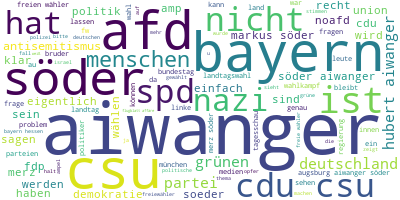

In [8]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
long_string = ",".join(german_sentiment_without_stop_words)
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=5, contour_color="steelblue")
wordcloud.generate(long_string)
wordcloud.to_image()

## Word Cloud after Lemmatize
Lemmatize with Spacy (https://spacy.io/models/de). Spacy uses models small to large and a BERT based model. We use *large*. 
This has to be installed via *pip* see link.
NLTK WORDNET does not work with the German language. 

In [9]:
data_words = []

for words in german_sentiment_without_stop_words:
    doc = nlp(words.lower())
    data_words.append([x.lemma_.lower() for x in doc])

# filter for stopwords after lemmatizing again, just to make sure
data_words = [[x for x in data_word if x not in stop_words] for data_word in data_words]
german_sentiment_df["lemma"] = data_words

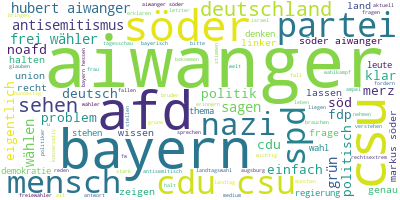

In [10]:
long_string = ",".join([x for data_word in data_words for x in data_word])
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=5, contour_color="steelblue")
wordcloud.generate(long_string)
wordcloud.to_image()

## WordClouds for each Party

Text(0.5, 1.0, 'AFD - 609 posts')

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'CSU - 1570 posts')

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'FDP - 94 posts')

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'FW - 2015 posts')

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'GRUENE - 54 posts')

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'LINKE - 69 posts')

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'SPD - 192 posts')

(-0.5, 399.5, 199.5, -0.5)

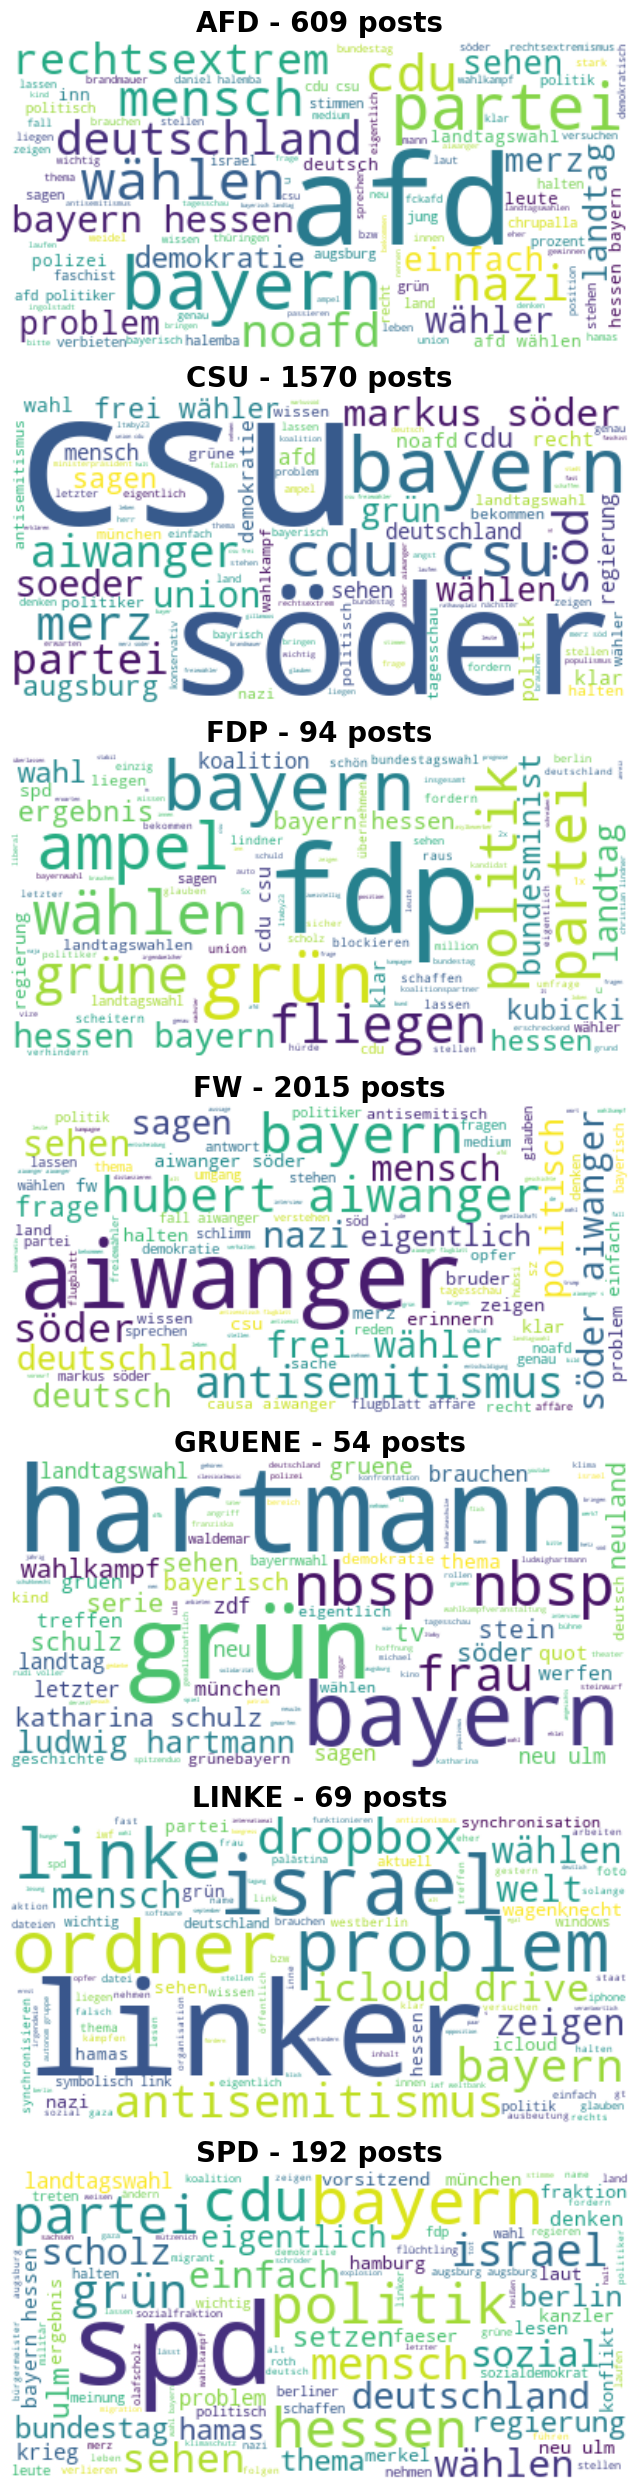

In [11]:
texts = german_sentiment_df.set_index("dominant_party").lemma
party_texts = {}
for i, v in texts.items():
    if i not in party_texts:
        party_texts[i] = [v]
    else:
        party_texts[i].append(v)
parties = set(german_sentiment_df.dominant_party)

fig, axs = plt.subplots(nrows=len(parties), ncols=1, figsize=(10, 25))

for i, party in enumerate(sorted(parties)):
    party_long_text = ",".join([word for text in party_texts[party] for word in text])
    wc = WordCloud(background_color="white", max_words=100, contour_width=5, contour_color="steelblue").generate(
        party_long_text
    )
    axs[i].imshow(wc, interpolation="bilinear")
    axs[i].set_title(f"{party.upper()} - {len(party_texts[party])} posts", fontsize=20, fontweight="bold")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [12]:
# Quelle: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# filter words that show up less than 15 times, more than 50% of the time and keep it to 10.000 Words
id2word.filter_extremes(no_below=15, no_above=0.50, keep_n=10000)

# Create Corpus
texts = data_words

# Term Document Frequency
# Converts a collection of words to  a list of (word_id, word_frequency) 2-tuples.
corpus = [id2word.doc2bow(text) for text in texts]

In [14]:
def get_model(
    _corpus: list, _id2word: corpora.Dictionary, _num_topics: int, random_state: float = 0
) -> gensim.models.LdaModel:
    """Get a Multicore Variant of the LDA-Model."""
    return gensim.models.LdaMulticore(
        corpus=_corpus, id2word=_id2word, num_topics=_num_topics, random_state=random_state
    )

In [15]:
num_topics = 15
lda_model = get_model(_corpus=corpus, _id2word=id2word, _num_topics=num_topics, random_state=2)
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.025933  0.042916       1        1  11.520717
5      0.003206 -0.031070       2        1  10.014102
11     0.006012 -0.009623       3        1   8.498561
0     -0.016391 -0.004960       4        1   7.731914
6      0.017905 -0.052395       5        1   7.383367
9     -0.008958  0.030921       6        1   6.220960
8      0.022406  0.000404       7        1   6.177058
13     0.021816 -0.035605       8        1   5.957312
4      0.014625 -0.008719       9        1   5.758086
12    -0.032700  0.063275      10        1   5.393529
3     -0.041595  0.004877      11        1   5.369493
7     -0.020247  0.008768      12        1   5.357709
1      0.000724  0.028720      13        1   5.012499
14     0.111507  0.022964      14        1   4.804449
2     -0.052378 -0.060473      15        1   4.800243, topic_info=            Term         Freq        To

In [16]:
pyLDAvis.enable_notebook()

<Axes: xlabel='week', ylabel='sentiment'>

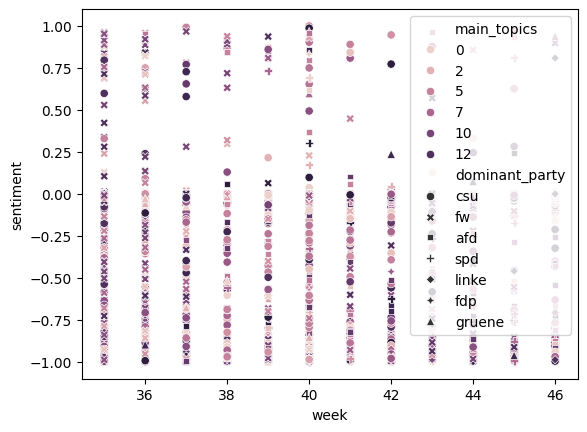

In [17]:
document_topics = list(lda_model.get_document_topics(corpus))


def get_main_topic(doc: list) -> int:
    """
    Get the topic index/number for the current document.

    Strongest topic in current document `doc`.
    """
    return max(doc, key=lambda x: x[1])[0]


main_topics = [get_main_topic(x) for x in document_topics]
german_sentiment_df["main_topics"] = main_topics

sns.scatterplot(data=german_sentiment_df, x="week", y="sentiment", hue="main_topics", style="dominant_party")

Filtering out by computing the mean(for groups of topic, week and party).

<Axes: xlabel='week', ylabel='sentiment'>

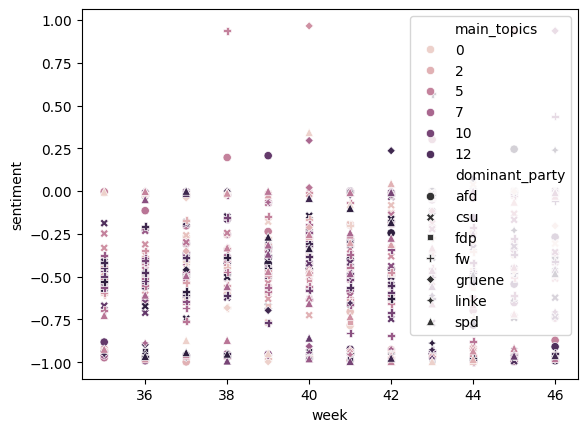

In [18]:
german_sentiment_df_p = (
    german_sentiment_df[["dominant_party", "week", "sentiment", "main_topics"]]
    .groupby(by=["dominant_party", "week", "main_topics"])
    .mean()
)
sns.scatterplot(data=german_sentiment_df_p, x="week", y="sentiment", hue="main_topics", style="dominant_party")

In [19]:
def get_most_important_word(model: gensim.models.LdaModel) -> dict[int, str]:
    """Get the most important word of a given model."""
    return {x[0]: x[1].split("*")[1][1:-1] for x in model.show_topics(num_words=1, num_topics=-1)}


get_most_important_word(lda_model)

{0: 'aiwanger',
 1: 'aiwanger',
 2: 'aiwanger',
 3: 'aiwanger',
 4: 'aiwanger',
 5: 'csu',
 6: 'bayern',
 7: 'aiwanger',
 8: 'aiwanger',
 9: 'aiwanger',
 10: 'aiwanger',
 11: 'aiwanger',
 12: 'aiwanger',
 13: 'csu',
 14: 'csu'}

In [20]:
german_sentiment_df_t = german_sentiment_df.copy()
german_sentiment_df_t["important_word"] = german_sentiment_df_t.main_topics.apply(
    lambda x: get_most_important_word(lda_model)[x]
)
german_sentiment_df_t

,date,day,week,mentioned_party,dominant_party,cleared_content,sentiment,lemma,main_topics,important_word
735,2023-09-01 00:27:55,244,35,csu,csu,jan buehlbecker AhaAchja dann veranstaltet söd...,-0.000032,"[jan, buehlbecker, ahaachja, veranstalten, söd...",3,aiwanger
736,2023-09-01 00:23:27,244,35,fw,fw,Der Antisemitismusbeauftragte der Bundesregier...,-0.000027,"[antisemitismusbeauftragt, bundesregierung, fe...",7,aiwanger
737,2023-09-01 00:17:34,244,35,fw,fw,Das dem Herrn Aiwanger nach mehreren Tagen imm...,-0.989762,"[herrn, aiwanger, mehrere, bitte, entschuldigu...",2,aiwanger
738,2023-09-01 00:00:08,244,35,fw,fw,"'Aktuell wichtiger denn je. Gell, Hubsi…😇 ' Ai...",-0.543437,"[aktuell, wichtig, gell, hubsi, 😇-, aiwanger, ...",11,aiwanger
739,2023-09-01 03:55:45,244,35,fw,fw,"Habe gerade im Deutschlandfunk gehört, dass au...",-0.011672,"[deutschlandfunk, gehören, bbc, fall, aiwanger...",10,aiwanger
...,...,...,...,...,...,...,...,...,...,...
5596,2023-11-18 19:00:36,322,46,afd,afd,RT by TerryReintke : Eine überfallartig gekape...,-0.002703,"[rt, by, terryreintke, überfallartig, gekapert...",11,aiwanger
5597,2023-11-18 20:08:06,322,46,afd,afd,"MuHa, großdeutscher AfD - NAZIPuff im bayrisch...",-0.427801,"[muha, großdeutsch, afd, nazipuff, bayrisch, n...",6,bayern
5598,2023-11-18 20:55:02,322,46,linke,linke,risa spirelli mich nervt es auch das man kaum ...,-0.986509,"[risa, spirelli, nerven, streiten, bloß, nörge...",12,aiwanger
5599,2023-11-18 22:04:01,322,46,fdp,fdp,"BerlinVic Es gibt zu viele Leute, die sie wähl...",-0.010498,"[berlinvic, leute, wählen, gemeinsam, wähnen, ...",3,aiwanger


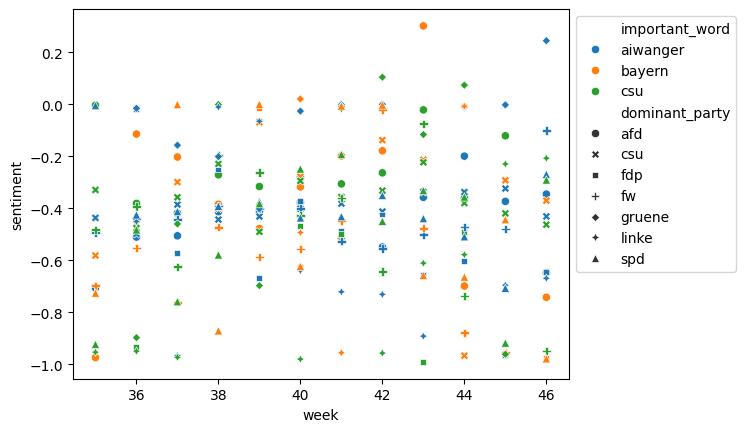

In [21]:
german_sentiment_df_t = (
    german_sentiment_df_t[["dominant_party", "week", "sentiment", "important_word"]]
    .groupby(by=["dominant_party", "week", "important_word"])
    .mean()
)
ax = sns.scatterplot(data=german_sentiment_df_t, x="week", y="sentiment", hue="important_word", style="dominant_party")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

In [22]:
profile = ProfileReport(
    german_sentiment_df,
    title="Profiling Report",
    correlations={
        "auto": {"calculate": True},
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": True},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": True},
    },
    interactions=None,
    duplicates=None,
    samples=None,
)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Seeing the phi_k correlatiion mesaure there is a medium correlation between dominant party and topic.
The sentiment seam to be weakly or not correlated.

## LDA - Topics

The actual topic index, may change a possible, tested result is:
Some Topics form cluster. The main cluster consists of the topics 1-6, 8, 10, 12 (Bavaria, CSU, Söder, AFD). A smaller cluster is 7 & 9 (CSU).

The weighting factor λ is applied to rank the terms. λ = 1, means ranking of terms in decreasing order of their *topic*-specific probability and λ = 0 ranking by lift (term probability within a topic over its marginal probability across the corpus). Meaning, λ = 1 favours total probability with the corpus and λ = 0 favours the probability with the current text (see https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

The clusters 11 (Freie Wähler, CSU), 13 (Söder, Bayern, AFD), 14 (Söder, Bayern) and 15 (Bayern) are isolated.
The most import terms are:

| Topic | Percentage | λ = 0                                                      | λ = 0.5                          | λ = 1                            |
|-------|-----------:|------------------------------------------------------------|----------------------------------|----------------------------------|
| 1     | 9.8        | Nazi, Augsburg                                             | CSU                              | CSU                              |
| 2     | 8.9        | 1, 25                                                      | Söder, CSU                       | Söder, CSU                       |
| 3     | 7.8        | Prozent                                                    | AFD, Bayern                      | AFD, Bayern                      |
| 4     | 7.7        | Hessen, Wählen (elect)                                     | Söder, Bayern                    | Söder, Bayern                    |
| 5     | 7.2        | Landtag (state parliament), Landtagswahl (state election)  | AFD, Söder, Bayern               | AFD, Söder, Bayern               |
| 6     | 7.1        | ltbwby23                                                   | CSU, Bayern                      | CSU, Bayern                      |
| 7     | 7.0        | werfen (through)                                           | CSU, Söder                       | CSU, Söder                       |
| 8     | 6.9        | *laughing emojis*, Isral, letzter (last)                   | CSU, Söder                       | CSU, Söder                       |
| 9     | 6.4        | DE, Fakt (fact)                                            | CSU                              | CSU, CDU                         |
| 10    | 5.8        | Welt (world), Opfer (victim)                               | Hubert, Söder                    | Hubert, Söder                    |
| 11    | 5.5        | Freie Wähler                                               | Freie Wähler, Hubert, CSU, Söder | Freie Wähler, CSU, Hubert, Söder |
| 12    | 5.2        | Hartmann                                                   | CSU, Bayern, AFD                 | CSU, Bayern, AFD                 |
| 13    | 5.0        | wissen (know, knowledge)                                   | Söder, Bayern, CSU               | Söder, Bayern, CSU               |
| 14    | 4.9        | Hubsi (nickname Hubert Aiwanger), Augsburg                 | Söder, Augsburg, Bayern          | Söder, Bayern                    |
| 15    | 4.7        | 2, FDP                                                     | Bayern                           | Bayern                           |

## LDA for each party with up to 15 topics

In [25]:
# Create Widgets
w_party = widgets.Select(
    options=parties,
    value="csu",
    description="Party:",
    disabled=False,
)
w_n = widgets.IntSlider(
    value=7,
    min=2,
    max=15,
    step=1,
    description="Topics:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
)

# Display Widgets


def update(selected_party: str, _num_topics: int) -> None:
    """Event to recompute the LDA when updating the number of TOPIC and the party."""
    print(f"Selected Party: {selected_party}")
    print(f"Number of Topics: {_num_topics}")

    _id2word = corpora.Dictionary(party_texts[selected_party])
    party_df = german_sentiment_df[german_sentiment_df.dominant_party == selected_party]
    _id2word.filter_extremes(no_below=15, no_above=0.50, keep_n=10000)

    # Term Document Frequency
    # Converts a collection of words to  a list of (word_id, word_frequency) 2-tuples.
    _corpus = [_id2word.doc2bow(text) for text in party_texts[w_party.value]]

    _lda_model = get_model(_corpus=_corpus, _id2word=id2word, _num_topics=_num_topics, random_state=2)
    lda_vis_prepared = pyLDAvis.gensim_models.prepare(_lda_model, corpus, id2word)
    display(lda_vis_prepared)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True, sharex=True)

    party_topics = list(_lda_model.get_document_topics(_corpus))
    party_df.loc[:, "main_topics"] = [get_main_topic(x) for x in party_topics]
    ax1 = sns.scatterplot(data=party_df, x="week", y="sentiment", hue="main_topics", style="dominant_party", ax=axes[0])
    ax1.set_title("Scatterplot 1: Sentiment by Main Topics")
    ax1.legend(loc="upper left", bbox_to_anchor=(1, 1))

    party_df.loc[:, "important_word"] = party_df.main_topics.apply(lambda x: get_most_important_word(_lda_model)[x])
    party_df = (
        party_df[["dominant_party", "week", "sentiment", "important_word"]]
        .groupby(by=["dominant_party", "week", "important_word"])
        .mean()
    )
    ax2 = sns.scatterplot(
        data=party_df, x="week", y="sentiment", hue="important_word", style="dominant_party", ax=axes[1]
    )
    ax2.set_title("Scatterplot 2: Sentiment by Most important word!")
    ax2.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    display(plt.show())


interact(update, selected_party=w_party, _num_topics=w_n)

interactive(children=(Select(description='Party:', options=('csu', 'gruene', 'spd', 'fw', 'linke', 'afd', 'fdp…

<function __main__.update(selected_party: str, _num_topics: int) -> None>